## Embeddings


Embeddings são representações numéricas que traduzem dados de alta dimensão, como texto, imagens ou áudio, em vetores de dimensão reduzida. Esses vetores preservam relações semânticas ou contextuais do dado original, permitindo que informações complexas sejam manipuladas de forma mais eficiente em cálculos e algoritmos.

No caso de textos, por exemplo, um embedding transforma palavras, frases ou documentos em números de tal forma que palavras com significados semelhantes fiquem próximas no espaço vetorial. Por exemplo, podemos dizer que a palavra homem está para a palavra rei, da mesma forma que a palavra mulher está para a palavra rainha. Esses significados semânticos servem como ferramenta para que possamos obter contextos dentro de situações em que precisamos dele.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader

from dotenv import load_dotenv
import os

from tqdm import tqdm

load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [3]:
embedding_size = 1536
embedding_model = "text-embedding-3-small"
embeddings = OpenAIEmbeddings(model=embedding_model, dimensions=embedding_size)

## Carregando os dados:

Instanciando o [`PyPDFLoader`](https://python.langchain.com/docs/integrations/document_loaders/pypdfloader/), temos um objeto de loader do lanchain. No momento em que essa classe é instanciada, colocamos o caminho do arquivo PDF que queremos ler, e o objeto resultante tem um método chamado .load(). 
Esse método permite a leitura do arquivo PDF, e o resultado é o texto presente no PDF dentro de um objeto "Document", que faz parte da biblioteca do langchain e é a base dessa dinâmica de leitura de documentos da biblioteca.

In [4]:
file_path_ed_financeira = "../data/educacao_financeira.pdf"
file_path_historia = "../data/historia.pdf"
loader_historia = PyPDFLoader(file_path_historia)
loader_ed_financeira = PyPDFLoader(file_path_ed_financeira)
pages_historia = loader_historia.load()
pages_ed_financeira = loader_ed_financeira.load()

In [5]:
# Concatenante todo o conteudo em uma string só

all_content_pages_historia = "\n\n".join([page.page_content for page in pages_historia])
all_content_pages_ed_financeira = "\n\n".join([page.page_content for page in pages_ed_financeira])

## Text Splitter

Utilizamos uma técnica de text splitting para quebrar os textos em chunks (fragmentos menores). Isso é interessante no nosso contexto porque facilita o processamento e a análise de textos longos em tarefas como classificação ou geração de respostas. 

[`Recursive Text Splitter`](https://python.langchain.com/docs/how_to/recursive_text_splitter/).

In [36]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,
    chunk_overlap=500,
    length_function=len,
    is_separator_regex=False,
)

In [37]:
##Aqui, temos como output uma lista de documents, onde cada document é um chunk do documento original
chunks_historia = text_splitter.split_documents(pages_historia)
chunks_ed_financeira = text_splitter.split_documents(pages_ed_financeira)

## Criando embeddings

Aqui, nós criamos os embeddings utilizando o [`OpenAIEmbeddings`](https://python.langchain.com/docs/integrations/text_embedding/openai/), e transformamos esses embeddings em arrays do numpy, que otimiza o uso desses embeddings para cálculos.

Criamos embeddings para os textos de história e educação financeira separadamente, e depois concatenamos (juntamos) os dois tipos de embeddings em um array só com todos os embeddings

In [38]:
vectors_historia = np.array(embeddings.embed_documents([chunk.page_content for chunk in chunks_historia]))

In [39]:
vectors_ed_financeira = np.array(embeddings.embed_documents([chunk.page_content for chunk in chunks_ed_financeira]))

In [40]:
all_vectors = np.concatenate([vectors_historia, vectors_ed_financeira], axis=0)

In [41]:
vectors_ed_financeira.shape, vectors_historia.shape, all_vectors.shape

((227, 1536), (333, 1536), (560, 1536))

## Reduzindo a dimensionalidade

Embeddings possuem uma quantidade significativa de dimensões. Para facilitar a compreensão, pense nas três dimensões que observamos no espaço ao nosso redor: altura, largura e profundidade. Com elas, conseguimos descrever a posição de qualquer objeto no espaço. Agora, imagine lidar com mais de 1000 dimensões. É impossível visualizar ou compreender intuitivamente esse espaço, mesmo que ele carregue significados importantes.

Para lidar com essa complexidade, utilizamos técnicas de redução de dimensionalidade, que permitem diminuir o número de dimensões sem perder as características principais dos dados. Uma dessas técnicas amplamente utilizadas é o t-SNE (t-Distributed Stochastic Neighbor Embedding). Essa técnica é capaz de projetar dados de alta dimensão em um espaço de dimensões menores, geralmente 2 ou 3, preservando as relações de proximidade entre os pontos no espaço original.

Não é necessário nos preocuparmos com os detalhes matemáticos dessa técnica, pois bibliotecas como o sklearn.manifold já oferecem implementações eficientes. Podemos utilizá-la para reduzir os nossos embeddings para 2 dimensões, permitindo que eles sejam visualizados em um plano 2D.

In [42]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
all_vectors_tsne = tsne.fit_transform(all_vectors)

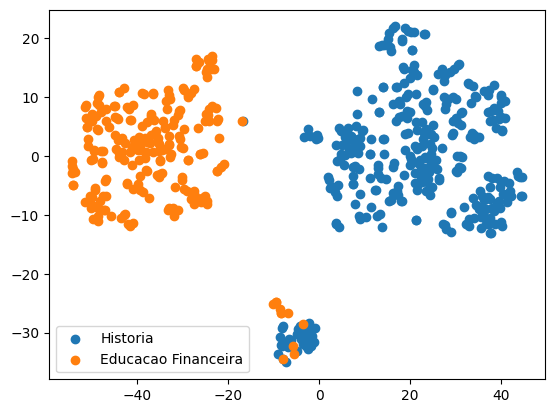

In [43]:
plt.scatter(all_vectors_tsne[:len(vectors_historia), 0], all_vectors_tsne[:len(vectors_historia), 1], label="Historia")
plt.scatter(all_vectors_tsne[len(vectors_historia):, 0], all_vectors_tsne[len(vectors_historia):, 1], label="Educacao Financeira")
plt.legend()
plt.show()

### Classificador 

Aqui, para confirmar a hipótese de que os embeddings carregam significado, construímos um classificador simples com a tarefa de prever a qual classe um chunk de texto pertence.

In [44]:
import torch 
import torch.nn as nn
from sklearn.model_selection import train_test_split

class Classifier(nn.Module):
    def __init__(self, 
                 input_size, 
                 hidden_size, 
                 output_size):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out
    
input_size = embedding_size
criterion = nn.CrossEntropyLoss()
classifier = Classifier(input_size, 100, 2)
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

X = torch.tensor(all_vectors, dtype=torch.float32)
y = torch.tensor([0]*len(vectors_historia) + [1]*len(vectors_ed_financeira), dtype=torch.long)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
for epoch in range(100):
    optimizer.zero_grad()
    outputs = classifier(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch} Loss: {loss.item()}")

Epoch 0 Loss: 0.6984750628471375
Epoch 1 Loss: 0.6883018612861633
Epoch 2 Loss: 0.6782520413398743
Epoch 3 Loss: 0.6673102974891663
Epoch 4 Loss: 0.6553820371627808
Epoch 5 Loss: 0.6426353454589844
Epoch 6 Loss: 0.6291877627372742
Epoch 7 Loss: 0.6152561902999878
Epoch 8 Loss: 0.6010456681251526
Epoch 9 Loss: 0.586675763130188
Epoch 10 Loss: 0.5722492337226868
Epoch 11 Loss: 0.5578405261039734
Epoch 12 Loss: 0.5435612201690674
Epoch 13 Loss: 0.529507040977478
Epoch 14 Loss: 0.5157324075698853
Epoch 15 Loss: 0.5023389458656311
Epoch 16 Loss: 0.4894258975982666
Epoch 17 Loss: 0.47707921266555786
Epoch 18 Loss: 0.4653610587120056
Epoch 19 Loss: 0.45431041717529297
Epoch 20 Loss: 0.44394782185554504
Epoch 21 Loss: 0.4342782497406006
Epoch 22 Loss: 0.4252975583076477
Epoch 23 Loss: 0.4169941246509552
Epoch 24 Loss: 0.40934744477272034
Epoch 25 Loss: 0.40233010053634644
Epoch 26 Loss: 0.3959091305732727
Epoch 27 Loss: 0.3900475800037384
Epoch 28 Loss: 0.3847059905529022
Epoch 29 Loss: 0.3798

In [46]:
from sklearn.metrics import accuracy_score, classification_report

outputs_test = classifier(X_test)
_, predicted = torch.max(outputs_test, 1)

print(accuracy_score(y_test, predicted))

1.0


In [47]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        73
           1       1.00      1.00      1.00        39

    accuracy                           1.00       112
   macro avg       1.00      1.00      1.00       112
weighted avg       1.00      1.00      1.00       112



## Entropia

A entropia é uma medida da incerteza ou desordem associada a uma distribuição de probabilidade. Em termos mais simples, ela indica o quão confuso ou "em dúvida" um sistema está ao tomar uma decisão. Em modelos de classificação, a entropia é frequentemente usada para avaliar o grau de incerteza nas previsões do modelo

Quando um classificador é treinado para categorizar chunks de texto em diferentes classes, ele gera uma distribuição de probabilidade para cada chunk, indicando a probabilidade de pertencer a cada classe. Se o modelo atribui alta probabilidade a uma única classe (baixa entropia), ele está confiante em sua previsão. Por outro lado, se as probabilidades estão espalhadas entre várias classes (alta entropia), o modelo está incerto sobre qual classe o chunk pertence.

In [48]:
def shannon_entropy(p):
    return -np.sum(p * np.log2(p))

all_outputs = classifier(X)
entropy = np.array([shannon_entropy(x) for x in all_outputs.detach().numpy()])
all_chunks = np.array([x.page_content for x in (chunks_historia + chunks_ed_financeira)])

df = pd.DataFrame({"entropy": entropy, 
                   "text": all_chunks, 
                   "label": y.numpy()})

In [49]:
df.sort_values("entropy", ascending=False).head(75)

,entropy,text,label
2,0.999217,Vitória \n2015\nUniVersidade Federal do espíri...,0
435,0.984450,70,1
436,0.966885,71,1
10,0.902574,8,0
506,0.844194,"Há muitos, muitos poucos anos, não existia cel...",1
...,...,...,...
222,0.120808,151,0
463,0.120421,"93\nPost 7\ndia 7 de junho, postado por Flávia...",1
515,0.118925,Se na minha época existisse celular \nteria da...,1
300,0.118816,fície é do tamanho da terra. É muito difícil q...,0


In [50]:
df.iloc[506, 1]

'Há muitos, muitos poucos anos, não existia celular. E, mesmo \nassim, as pessoas conseguiam se encontrar. Naquela época, \nos pais e as mães esperavam os filhos em casa pacientemen-\nte, já que não podiam ligar o tempo todo. E mensagem de tex-\nto só existia nos bilhetes passados em sala de aula, no tempo \nem que “vc” era você!\nli gar pela primeira vez para uma menina de quem você está \nafim antes de existir o celular:\nPaulo liGa Para a casa da marina (17:30): Triiiim... \nTriiiiim...\nirmão mais vElho, ciumEnTo E muiTo forTE da \nmarina: ALÔ!!!!!!!\nPaulo dEsliGa: Tú, tú, tú, tú.\nPaulo liGa Para a casa da marina (18:43): Triiiim... \nTriiiiim.... Triiiiiiimmmm....\nPai da marina aTEndE: Pronto.\nPaulo dEsliGa: Tú, tú, tú, tú.\ndia sEGuinTE, Paulo liGa Para a casa da marina \n(19:01): Triiiim... Triiiiim....\nmãE da marina aTEndE: Oi!\nPaulo dEsliGa: Tú, tú, tú, tú.\nTrÊs dias dEPois, Paulo liGa Para a casa da marina \n(17:06): Triiiim... Triiiiim... Triiiiiiimmmm...\nmarina aTEn

In [51]:
df.sort_values("entropy", ascending=True).head(15)

,entropy,text,label
476,0.003863,eXPe ri MeNt e! >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>...,1
390,0.003919,(Taxa de Referência). O valor da remuneração d...,1
421,0.004195,tre para eles para que digam se você passou pe...,1
394,0.004221,33\n7 pRODuTO supéRFLuO CaRO aO aLCaNCe DO CLI...,1
232,0.004378,"158\nEssa filosofia, proveniente do mundo orie...",0
362,0.004422,8\nqu em tem muito \nd i n h e i r o é c o m...,1
420,0.004521,57\n j an f ev Mar a br Mai j un j ul a go s e...,1
398,0.005056,37\nPrimeiro converse sobre isso em casa. As p...,1
167,0.005172,"118\nséculo xii e inícios do século xiii, o pr...",0
472,0.005227,"Além da ilusão de ter mais dinheiro, há outro ...",1


In [52]:
df['high_entropy'] = df['entropy'] > 0.2

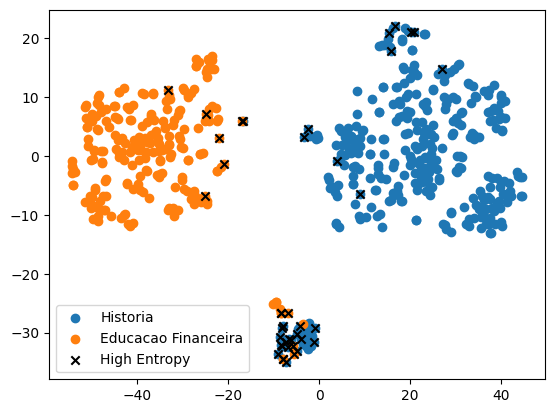

In [53]:
plt.scatter(all_vectors_tsne[:len(vectors_historia), 0], all_vectors_tsne[:len(vectors_historia), 1], label="Historia")
plt.scatter(all_vectors_tsne[len(vectors_historia):, 0], all_vectors_tsne[len(vectors_historia):, 1], label="Educacao Financeira")
plt.scatter(all_vectors_tsne[df['high_entropy'] == 1, 0], all_vectors_tsne[df['high_entropy'] == 1, 1], label="High Entropy", color="black", marker="x")
plt.legend()
plt.show()

# Para hoje/amanhã

1. Escolham duas playlists do youtube com temas distintos ou realizem scrapping de conteúdos distintos
2. Tomem os embeddings dos vídeos/conteúdos
3. Comparem os embeddings de cada segmento em um gráfico bidimensional.
4. Treinem um classificador em cima dos embeddings dos chunks.
5. Analisem quais chunks o modelo treinado mais teve dificuldade em classificar.
6. **(EXTRA/DESAFIO)**: Busquem o 'tema' central dos conteúdos (ou seja, identifique os centróides dos embeddings); Selecione um dos temas centrais e busque os chunks/embeddings que estão mais relacionados a este tema central (vocês podem utilizar a famosa `similaridade cosseno` from scratch mesmo para buscar os embeddings mais próximos --- semanticamente --- e consequentemente os chunks associados)